# Generating Secondary Eclipse Emission Spectra

This tutorial demonstrates how to compute the emission spectrum of a transiting exoplanet at secondary eclipse (i.e. $F_p / F_*$).

### Stellar Spectrum

Since emission spectra are normalised to the stellar flux, we need to know $F_*$. POSEIDON can automatically compute $F_*$ when initialising the star object, either by interpolating grids of stellar models to the provided stellar properties or assuming a black body.

This tutorial will focus on the ultra-hot Jupiter WASP-121b.

Let's start by loading a PHOENIX stellar spectrum with stellar properties corresponding to WASP-121.

In [1]:
from POSEIDON.core import create_star, wl_grid_constant_R
from POSEIDON.constants import R_Sun

#***** Create wavelength grid for our star and planet spectrum *****#
 
wl_min = 0.3      # Minimum wavelength (um)
wl_max = 10.0     # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define stellar properties *****#

# Stellar properties below from ExoMast for WASP-121

R_s = 1.46*R_Sun      # Stellar radius (m)
T_s = 6776.0          # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.24        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

We can quickly plot the stellar spectrum.

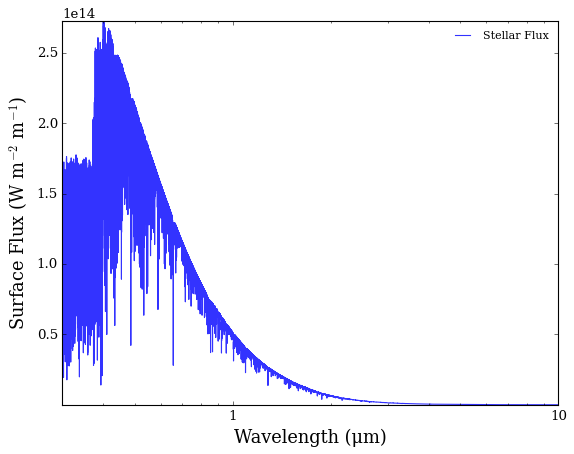

In [2]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Load stellar spectrum and wavelength grid from the star object
F_s = star['F_star']
wl_s = star['wl_star']

# Create stellar spectra plotting object
spectra = []
spectra = plot_collection(F_s, wl_s, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, None, R_to_bin = 100, plot_full_res = True,
                        spectra_labels = ['Stellar Spectrum'],
                        y_unit = 'Fs',                # This switches plot units from to flux
                        colour_list = ['crimson'],
                        wl_axis = 'log',
                        save_fig = False)

### A Simple Dayside Model

Let's construct a simple model atmosphere with a vertical temperature gradient (as we'll see later, emission spectra are very sensitive to the pressure-temperature profile).

We first provide the planet properties for WASP-121b.

In [3]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J

#***** Define planet properties *****#

planet_name = 'WASP-121b'  # Planet name used for plots, output files etc.

R_p = 1.753*R_J    # Planetary radius (m)
M_p = 1.157*M_J    # Mass of planet (kg)
T_eq = 2450          # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

This time, we'll choose a 'gradient' P-T profile instead of an isotherm.

In [4]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Simple_dayside'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']    # H2 + He comprises the bulk atmosphere
param_species = ['H2O']        # The only trace gas is H2O

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'gradient')

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'T_high' 'T_deep' 'log_H2O']


Next, we choose specific values of the model parameters to create an atmosphere. We'll use $T_{\rm{high}}$ = 1500 K and $T_{\rm{deep}}$ = 3000 K.

In [5]:
from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1.0e-2   # Reference pressure (bar)
R_p_ref = R_p    # Radius at reference pressure

# Specify equilibrium grid values 
C_to_O = 0.55
log_Met = 0 

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([1500, 3000])    # T_high, T_deep
log_X_params = np.array([[-3.3]])     # log(H2O)

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

Let's see what our atmosphere looks like.

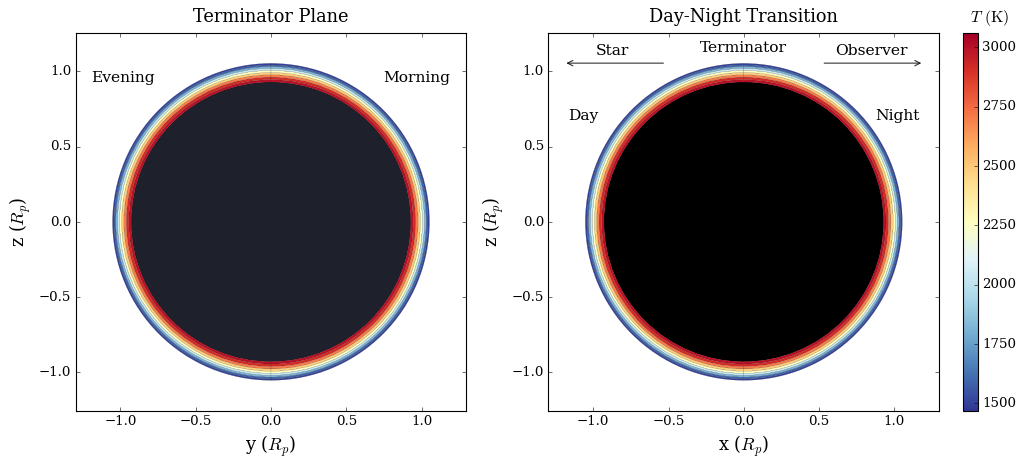

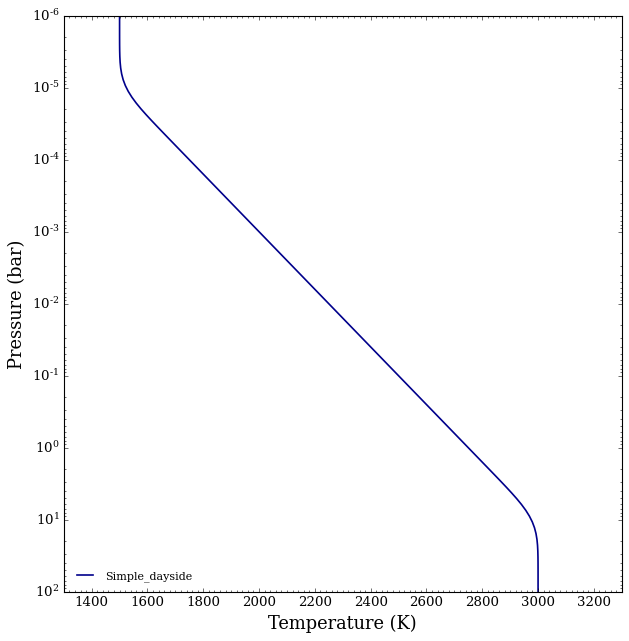

In [6]:
from POSEIDON.visuals import plot_geometry, plot_PT

# Produce plots of atmospheric properties
fig_geom = plot_geometry(planet, star, model, atmosphere)
fig_PT = plot_PT(planet, model, atmosphere)

Note that the dayside and nightside of this planet actually both share the same P-T profile, since this is a 1D model (the only atmospheric variations are in the radial direction).

Now let's read in the opacities for our model.

In [7]:
from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 1000    # 1000 K lower limit
T_fine_max = 3500    # 3500 K upper limit
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


### Computing Emission Spectra

Finally, we can generate the emission spectrum of our planet.

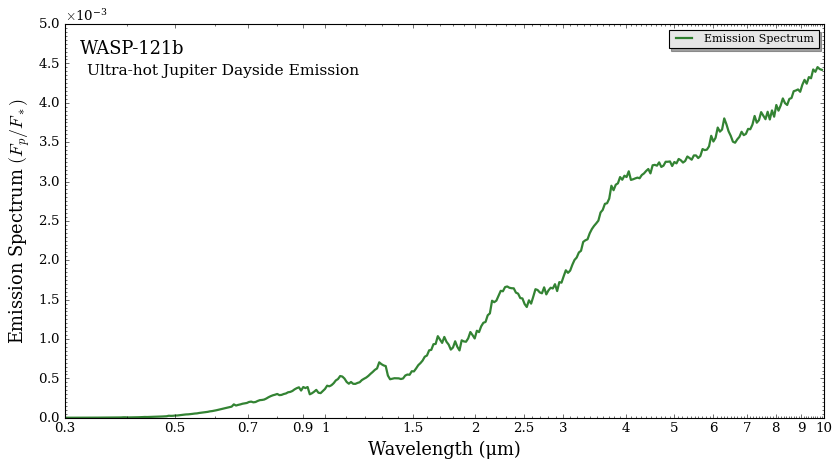

In [8]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate planet emission spectrum
Fp_Fs = compute_spectrum(planet, star, model, atmosphere, opac, wl, 
                         spectrum_type = 'emission')   # Note the change in spectrum type

spectra = []
spectra = plot_collection(Fp_Fs, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        spectra_labels = ['Emission Spectrum'],
                        y_min = 0.0, y_max = 5.0e-3, y_unit = 'Fp/Fs',  # This switches plot units from transmission to emission spectra
                        colour_list = ['darkgreen'],
                        plt_label = 'Ultra-hot Jupiter Dayside Emission',
                        wl_axis = 'log', figure_shape = 'wide')